<a href="https://colab.research.google.com/github/h350yam/SSSL/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Система для сбора событий и логов на тему - "Анализ логов"**
#**Практическая работа №2 по предмету**

Выполнил студент - **Ионов Максим Сергеевич** группы: **ББМО-02-23**

## **Вариант задания:**

В списке группы - **9**

Расчет варианта - **9 % 16 + 1 = 10**

В качестве логов по варианту - **`OpenSSH`** в репозитории **`loghub`**

## **1 - Загрузка файлов из репозитория `loghub` в рабочую область проекта:**

In [ ]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 575 (delta 145), reused 134 (delta 133), pack-reused 404 (from 2)
Receiving objects: 100% (575/575), 7.27 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (266/266), done.


## **2 - Создание регулярного выражения для парсинга логов:**

Для примера возьмем строчку из логов `OpenSSH`:

`Dec 10 06:55:46 LabSZ sshd[24200]: reverse mapping checking getaddrinfo for ns.marryaldkfaczcz.com [173.234.31.186] failed - POSSIBLE BREAK-IN ATTEMPT!`

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

1. (\d+) — LineId: Номер строки (добавим его вручную при обработке, так как в самих логах его нет, начнем с 1).
2. (\w{3}\s+\d{1,2}) — Date: Дата в формате "Dec 10".
3. (\d{1,2}) — Day: День (число от 1 до 31, уже включено в Date, но выделяем отдельно для точности).
4. (\d{2}:\d{2}:\d{2}) — Time: Время в формате "HH:MM:SS".
5. (\S+) — Component: Компонент (например, "sshd").
6. (\d+) — Pid: PID процесса (например, "24200").
7. (.+) — Content: Всё остальное сообщение логов.


**Реализация регулярного выражения:**

In [ ]:
pattern = r'(^[A-Za-z]{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2})\s+(\w+)\s+sshd\[(\d+)\]:\s+(.*)'

## **3 - Cоздание базы данных для хранения записей полученных логов:**

In [ ]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

import sqlite3

db_path = './db/log-db.db'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (Id INTEGER PRIMARY KEY AUTOINCREMENT, Datetime TEXT, Host TEXT, Component TEXT, Message TEXT)")

connection.commit()
cursor.close()
connection.close()

## **4 - Парсинг логов `OpenSSH` и сохранение полученных данных в БД:**

In [ ]:
import sqlite3
import re

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DELETE FROM logs")

with open('./loghub/OpenSSH/OpenSSH_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            datetime = log_match.group(1)
            host = log_match.group(2)
            component = f'sshd[{log_match.group(3)}]'
            message = log_match.group(4)
            values = (datetime, host, component, message)
            sql = "INSERT INTO logs (Datetime, Host, Component, Message) VALUES (?, ?, ?, ?)"
            cursor.execute(sql, values)

connection.commit()
cursor.close()
connection.close()

## **5 - Чтению данных, записанных ранее в БД:**

In [ ]:
import pandas as pd

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=("Id", "DateTime", "Host", "Component", "Message"))
log_df

,Id,DateTime,Host,Component,Message
0,1,Dec 10 06:55:46,LabSZ,sshd[24200],reverse mapping checking getaddrinfo for ns.ma...
1,2,Dec 10 06:55:46,LabSZ,sshd[24200],Invalid user webmaster from 173.234.31.186
2,3,Dec 10 06:55:46,LabSZ,sshd[24200],input_userauth_request: invalid user webmaster...
3,4,Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): check pass; user unknown
4,5,Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): authentication failure; l...
...,...,...,...,...,...
1995,1996,Dec 10 11:04:42,LabSZ,sshd[25539],pam_unix(sshd:auth): authentication failure; l...
1996,1997,Dec 10 11:04:43,LabSZ,sshd[25541],Failed password for root from 183.62.140.253 p...
1997,1998,Dec 10 11:04:43,LabSZ,sshd[25541],Received disconnect from 183.62.140.253: 11: B...
1998,1999,Dec 10 11:04:43,LabSZ,sshd[25544],pam_unix(sshd:auth): authentication failure; l...


## **6 - Нормализация полученных данных и запись новой версии в БД:**

### **6.1 - Нормализация Даты и времени (уберем секунды):**

In [ ]:
import sqlite3

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Добавляем год 2023 для полноты даты
cursor.execute("UPDATE logs SET Datetime = '2023 ' || Datetime")

connection.commit()
cursor.close()
connection.close()

# Проверка результата
connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()
cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=("Id", "DateTime", "Host", "Component", "Message"))
log_df

,Id,DateTime,Host,Component,Message
0,1,2023 Dec 10 06:55:46,LabSZ,sshd[24200],reverse mapping checking getaddrinfo for ns.ma...
1,2,2023 Dec 10 06:55:46,LabSZ,sshd[24200],Invalid user webmaster from 173.234.31.186
2,3,2023 Dec 10 06:55:46,LabSZ,sshd[24200],input_userauth_request: invalid user webmaster...
3,4,2023 Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): check pass; user unknown
4,5,2023 Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): authentication failure; l...
...,...,...,...,...,...
1995,1996,2023 Dec 10 11:04:42,LabSZ,sshd[25539],pam_unix(sshd:auth): authentication failure; l...
1996,1997,2023 Dec 10 11:04:43,LabSZ,sshd[25541],Failed password for root from 183.62.140.253 p...
1997,1998,2023 Dec 10 11:04:43,LabSZ,sshd[25541],Received disconnect from 183.62.140.253: 11: B...
1998,1999,2023 Dec 10 11:04:43,LabSZ,sshd[25544],pam_unix(sshd:auth): authentication failure; l...


#### **6.1.1 - Проверка результата нормализации DateTime:**

In [ ]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("SELECT * FROM logs ORDER BY Datetime")
sorted_rows = cursor.fetchall()

cursor.close()
connection.close()

log_df = pd.DataFrame(sorted_rows, columns=("Id", "DateTime", "Host", "Component", "Message"))
log_df

,Id,DateTime,Host,Component,Message
0,1,2023 Dec 10 06:55:46,LabSZ,sshd[24200],reverse mapping checking getaddrinfo for ns.ma...
1,2,2023 Dec 10 06:55:46,LabSZ,sshd[24200],Invalid user webmaster from 173.234.31.186
2,3,2023 Dec 10 06:55:46,LabSZ,sshd[24200],input_userauth_request: invalid user webmaster...
3,4,2023 Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): check pass; user unknown
4,5,2023 Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): authentication failure; l...
...,...,...,...,...,...
1995,1996,2023 Dec 10 11:04:42,LabSZ,sshd[25539],pam_unix(sshd:auth): authentication failure; l...
1996,1997,2023 Dec 10 11:04:43,LabSZ,sshd[25541],Failed password for root from 183.62.140.253 p...
1997,1998,2023 Dec 10 11:04:43,LabSZ,sshd[25541],Received disconnect from 183.62.140.253: 11: B...
1998,1999,2023 Dec 10 11:04:43,LabSZ,sshd[25544],pam_unix(sshd:auth): authentication failure; l...


### **6.2 - Сортировка таблицы по LogLevel и выгрузка результата:**

In [ ]:
import sqlite3
import pandas as pd

db_path = './db/log-db.db'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("SELECT * FROM logs ORDER BY Component")
sorted_rows = cursor.fetchall()

cursor.close()
connection.close()

log_df = pd.DataFrame(sorted_rows, columns=("Id", "DateTime", "Host", "Component", "Message"))
log_df

,Id,DateTime,Host,Component,Message
0,1,2023 Dec 10 06:55:46,LabSZ,sshd[24200],reverse mapping checking getaddrinfo for ns.ma...
1,2,2023 Dec 10 06:55:46,LabSZ,sshd[24200],Invalid user webmaster from 173.234.31.186
2,3,2023 Dec 10 06:55:46,LabSZ,sshd[24200],input_userauth_request: invalid user webmaster...
3,4,2023 Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): check pass; user unknown
4,5,2023 Dec 10 06:55:46,LabSZ,sshd[24200],pam_unix(sshd:auth): authentication failure; l...
...,...,...,...,...,...
1995,2000,2023 Dec 10 11:04:45,LabSZ,sshd[25539],Failed password for invalid user user from 103...
1996,1992,2023 Dec 10 11:04:41,LabSZ,sshd[25541],pam_unix(sshd:auth): authentication failure; l...
1997,1997,2023 Dec 10 11:04:43,LabSZ,sshd[25541],Failed password for root from 183.62.140.253 p...
1998,1998,2023 Dec 10 11:04:43,LabSZ,sshd[25541],Received disconnect from 183.62.140.253: 11: B...


## **7 - Осуществление статистического анализа и визуализации результатов:**

### **7.1 - Статистический анализ DateTime и выгрузка его визуализации:**

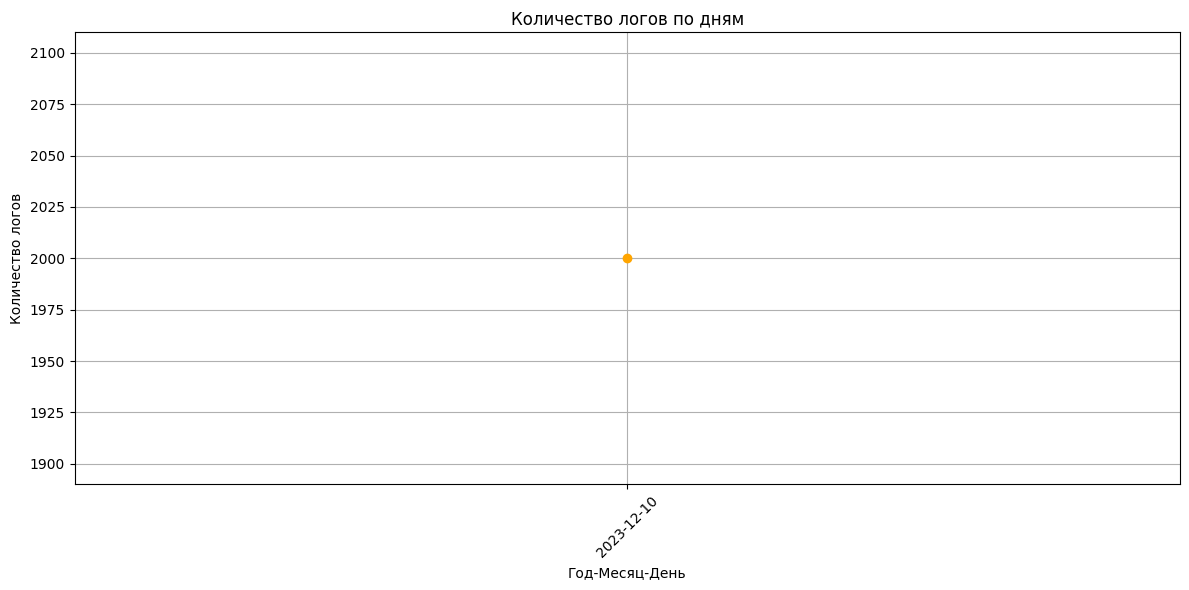

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM logs", conn)

df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y %b %d %H:%M:%S')
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day

daily_log_counts = df.groupby(['Year', 'Month', 'Day']).size().reset_index(name='LogCount')
daily_log_counts['YearMonthDay'] = daily_log_counts['Year'].astype(str) + '-' + \
                                   daily_log_counts['Month'].astype(str).str.zfill(2) + '-' + \
                                   daily_log_counts['Day'].astype(str).str.zfill(2)

plt.figure(figsize=(12, 6))
plt.plot(daily_log_counts['YearMonthDay'], daily_log_counts['LogCount'], marker='o', color='orange')
plt.title('Количество логов по дням')
plt.xlabel('Год-Месяц-День')
plt.ylabel('Количество логов')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### **7.2 - Статистический анализ LogLevel и выгрузка полученного результата:**

MessageType
Failed password for                             518
pam_unix(sshd:auth): authentication failure;    494
Received disconnect from                        421
pam_unix(sshd:auth): check pass;                135
input_userauth_request: invalid user            113
                                               ... 
Invalid user nagios                               1
Invalid user www                                  1
Invalid user abc                                  1
Invalid user ted                                  1
fatal: Write failed:                              1
Name: count, Length: 78, dtype: int64


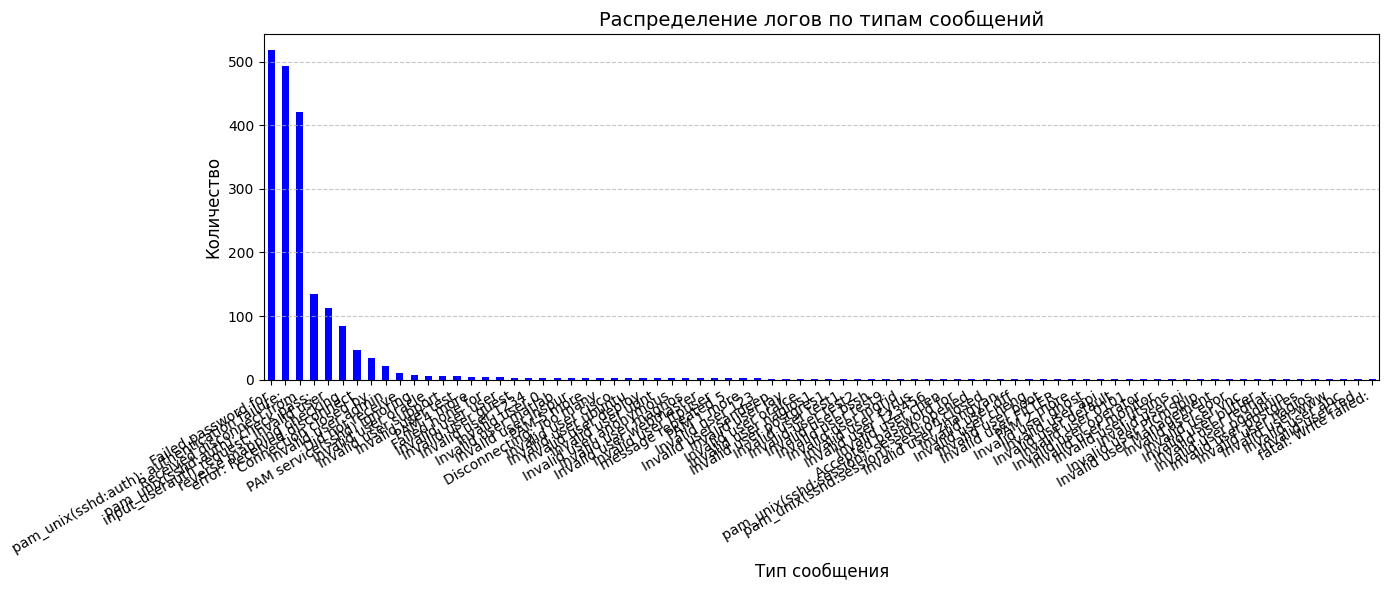

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('./db/log-db.db')
df = pd.read_sql_query("SELECT * FROM logs", conn)

df['MessageType'] = df['Message'].str.split().str[0:3].str.join(' ')
message_counts = df['MessageType'].value_counts()
print(message_counts)

plt.figure(figsize=(14, 6))
message_counts.plot(kind='bar', color='blue')
plt.title('Распределение логов по типам сообщений', fontsize=14)
plt.xlabel('Тип сообщения', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(
    range(0, len(message_counts), 1),
    message_counts.index,
    rotation=30,
    ha='right',
    fontsize=10
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

conn.close()

In [ ]:
# Разорвем соединение с БД:
conn.close()